In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [ ]:
# import datasets
# print(datasets.__version__)

In [2]:
import json
import time
import os
import pandas as pd
import numpy as np
import re
from copy import deepcopy

In [3]:
import torch

from transformers import BertForSequenceClassification

### Dataset

### Model, Tokenizer

In [4]:
fine_tune_path = '/content/drive/MyDrive/ClinicalNotesGen/RoleClassifier'
dataset_path = "/content/drive/MyDrive/ClinicalNotesGen/Data/speaker_role"

In [11]:
checkpoints_path = f"{fine_tune_path}/Train_3/Checkpoints/checkpoint-180"
final_checkpoints_path = f"{fine_tune_path}/Train_3/Final_Checkpoints"

In [6]:
# read parquet
test_df = pd.read_parquet(f"{dataset_path}/test.parquet")

In [7]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Tokenizer

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LENGTH = 260

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

####  FT model

In [12]:
model_path = final_checkpoints_path
model = BertForSequenceClassification.from_pretrained(model_path).to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
print_trainable_parameters(model)

trainable params: 109483778 || all params: 109483778 || trainable%: 100.0


#### Check

In [14]:
print("Base model class:", type(model))

Base model class: <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>


In [15]:
# Load trainer_state.json
trainer_state_path = os.path.join(checkpoints_path, "trainer_state.json")
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    # Print training and evaluation metrics
    for log in trainer_state["log_history"]:
        step = log.get("step", "N/A")
        train_loss = log.get("loss", "N/A")
        eval_loss = log.get("eval_loss", "N/A")
        print(f"Step {step}: Train Loss = {train_loss}, Eval Loss = {eval_loss}")
else:
    print("No trainer_state.json found. Check if training completed successfully.")

Step 20: Train Loss = 0.6456, Eval Loss = N/A
Step 20: Train Loss = N/A, Eval Loss = 0.49856457114219666
Step 40: Train Loss = 0.432, Eval Loss = N/A
Step 40: Train Loss = N/A, Eval Loss = 0.33454978466033936
Step 60: Train Loss = 0.2879, Eval Loss = N/A
Step 60: Train Loss = N/A, Eval Loss = 0.2142486274242401
Step 80: Train Loss = 0.1782, Eval Loss = N/A
Step 80: Train Loss = N/A, Eval Loss = 0.12002716213464737
Step 100: Train Loss = 0.0922, Eval Loss = N/A
Step 100: Train Loss = N/A, Eval Loss = 0.04810235649347305
Step 120: Train Loss = 0.0328, Eval Loss = N/A
Step 120: Train Loss = N/A, Eval Loss = 0.013560584746301174
Step 140: Train Loss = 0.0132, Eval Loss = N/A
Step 140: Train Loss = N/A, Eval Loss = 0.0072619314305484295
Step 160: Train Loss = 0.0047, Eval Loss = N/A
Step 160: Train Loss = N/A, Eval Loss = 0.00455578975379467
Step 180: Train Loss = 0.0029, Eval Loss = N/A
Step 180: Train Loss = N/A, Eval Loss = 0.004218893591314554


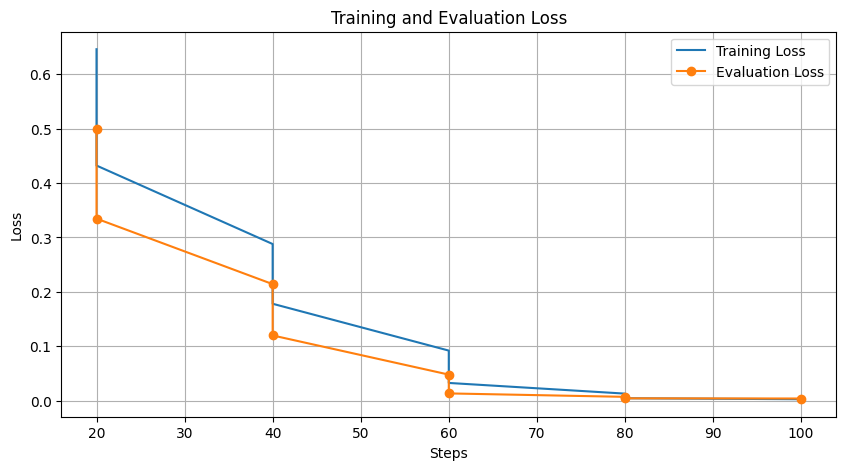

In [16]:
import matplotlib.pyplot as plt

steps = []
train_losses = []
eval_losses = []
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    for log in trainer_state["log_history"]:
        step = log.get("step")
        if "loss" in log:
            steps.append(step)
            train_losses.append(log["loss"])
            eval_losses.append(None)
        if "eval_loss" in log:
            steps.append(step)
            eval_losses[-1] = log["eval_loss"]

    plt.figure(figsize=(10, 5))
    plt.plot(steps[:len(train_losses)], train_losses, label="Training Loss")
    plt.plot([s for s, e in zip(steps, eval_losses) if e is not None],
             [e for e in eval_losses if e is not None],
             label="Evaluation Loss", marker="o")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No trainer_state.json found.")

# Test set

In [17]:
def get_response(dialogue, tokenizer, model):
    inputs = tokenizer(dialogue, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = logits.argmax(dim=-1).item()
    label_map = {0: "doctor", 1: "patient"}  # or reverse depending on your training labels
    predicted_role = label_map[predicted_class_id]
    print(f"Predicted speaker role: {predicted_role}")

### Test 1 sample

In [18]:
test_df.head(3)

,dialogue_index,speaker_role,text,utterance_count,dialogue_length,turn_indices
0,7420,patient,"Hi, doctor. I'm a 61-year-old white woman with...",8,17,"[1, 3, 5, 7, 9, 11, 13, 15]"
1,8174,doctor,"Hello, how can I help you today? I see. Can yo...",9,19,"[0, 2, 4, 6, 8, 10, 14, 16, 18]"
2,2028,doctor,"Hello, I see that you're a 35-year-old woman w...",11,20,"[0, 2, 4, 6, 8, 10, 12, 14, 15, 17, 19]"


In [19]:
sample_text = test_df.iloc[0]["text"]
sample_role = test_df.iloc[0]["speaker_role"]
print("Referece: ", sample_role)
get_response(sample_text, tokenizer, model)

Referece:  patient
Predicted speaker role: patient


In [20]:
sample_text = test_df.iloc[1]["text"]
sample_role = test_df.iloc[1]["speaker_role"]
print("Referemce: ", sample_role)
get_response(sample_text, tokenizer, model)

Referemce:  doctor
Predicted speaker role: doctor


In [21]:
sample_text = test_df.iloc[20]["text"]
sample_role = test_df.iloc[20]["speaker_role"]
print("Reference: ", sample_role)
get_response(sample_text, tokenizer, model)

Reference:  doctor
Predicted speaker role: doctor


### Evaluate test set

In [22]:
from sklearn.metrics import accuracy_score, f1_score

In [23]:
def evaluate_test_set(test_df, tokenizer, model, verbose=False):
    label_map = {0: "doctor", 1: "patient"}
    inverse_label_map = {v: k for k, v in label_map.items()}

    all_preds = []
    all_labels = []
    all_indices = []

    for idx, row in test_df.iterrows():
        dialogue = row["text"]
        true_label = row["speaker_role"]

        # Tokenize and predict
        inputs = tokenizer(dialogue, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class_id = logits.argmax(dim=-1).item()

        pred_label = label_map[predicted_class_id]
        all_preds.append(pred_label)
        all_labels.append(true_label)
        all_indices.append(idx)

        if verbose:
            print(f"Index: {idx} | Prediction: {pred_label} | Ground Truth: {true_label}")

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"\nTest Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    return {
        "accuracy": acc,
        "f1_score": f1,
        "indices": all_indices,
        "predictions": all_preds,
        "labels": all_labels
    }


In [24]:
results = evaluate_test_set(test_df, tokenizer, model, verbose=True)

Index: 0 | Prediction: patient | Ground Truth: patient
Index: 1 | Prediction: doctor | Ground Truth: doctor
Index: 2 | Prediction: doctor | Ground Truth: doctor
Index: 3 | Prediction: patient | Ground Truth: patient
Index: 4 | Prediction: doctor | Ground Truth: doctor
Index: 5 | Prediction: doctor | Ground Truth: doctor
Index: 6 | Prediction: doctor | Ground Truth: doctor
Index: 7 | Prediction: patient | Ground Truth: patient
Index: 8 | Prediction: patient | Ground Truth: patient
Index: 9 | Prediction: doctor | Ground Truth: doctor
Index: 10 | Prediction: patient | Ground Truth: patient
Index: 11 | Prediction: doctor | Ground Truth: doctor
Index: 12 | Prediction: patient | Ground Truth: patient
Index: 13 | Prediction: doctor | Ground Truth: doctor
Index: 14 | Prediction: doctor | Ground Truth: doctor
Index: 15 | Prediction: doctor | Ground Truth: doctor
Index: 16 | Prediction: patient | Ground Truth: patient
Index: 17 | Prediction: doctor | Ground Truth: doctor
Index: 18 | Prediction: 

In [25]:
print("Accuracy: {:.4f}".format(results["accuracy"]))
print("F1_score: {:.4f}".format(results["f1_score"]))

Accuracy: 1.0000
F1_score: 1.0000


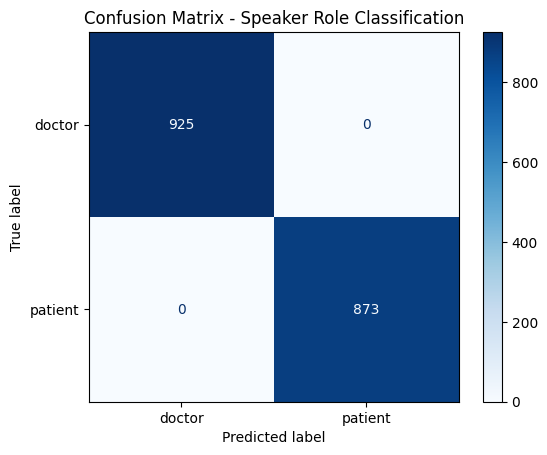

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = results["labels"]
preds = results["predictions"]

cm = confusion_matrix(labels, preds, labels=["doctor", "patient"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["doctor", "patient"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Speaker Role Classification")
plt.show()

### Test transcript

In [27]:
from collections import defaultdict

def group_text_by_speaker(utterances):
    """
    Groups dialogue text by speaker.

    Parameters:
    - utterances: list of dicts with 'speaker' and 'text' keys

    Returns:
    - grouped: dict mapping speaker to concatenated text
    """
    grouped = defaultdict(list)
    for utt in utterances:
        grouped[utt["speaker"]].append(utt["text"])

    # Concatenate all utterances from each speaker
    grouped_text = {speaker: " ".join(texts) for speaker, texts in grouped.items()}
    return grouped_text

In [28]:
dialogue = [
    {"speaker": "SPEAKER_01", "text": "Hi Doctor, I've been having this dull pain in my lower back for about a week now."},
    {"speaker": "SPEAKER_00", "text": "I'm sorry to hear that. Can you describe the pain? Does it radiate anywhere?"},
    {"speaker": "SPEAKER_01", "text": "It's mostly in the lower back, and sometimes it shoots down my left leg."}
]

In [39]:
grouped = group_text_by_speaker(dialogue)
print(grouped)

{'SPEAKER_01': "Hi Doctor, I've been having this dull pain in my lower back for about a week now. It's mostly in the lower back, and sometimes it shoots down my left leg.", 'SPEAKER_00': "I'm sorry to hear that. Can you describe the pain? Does it radiate anywhere?"}


In [40]:
get_response(grouped["SPEAKER_01"], tokenizer, model)

Predicted speaker role: patient


In [41]:
get_response(grouped["SPEAKER_00"], tokenizer, model)

Predicted speaker role: patient


In [32]:
def load_from_json(filename):
    """
    Load the conversation from a JSON file.
    """
    with open(filename, 'r') as f:
        return json.load(f)

In [33]:
transcript_1 = load_from_json("/content/drive/MyDrive/ClinicalNotesGen/Data/transcripts/en/encounter_fever_transcript.json")

In [34]:
transcript_1

[{'speaker': 'Patient',
  'start': 7.66,
  'end': 11.32,
  'text': 'Hi. My name is John Burke.'},
 {'speaker': 'Patient',
  'start': 12.62,
  'end': 16.04,
  'text': 'I have an appointment to see Dr. Gray.'},
 {'speaker': 'Doctor',
  'start': 38.3,
  'end': 41.6,
  'text': 'What seems to be the trouble, Mr. Burke?'},
 {'speaker': 'Patient',
  'start': 42.64,
  'end': 44.46,
  'text': 'I feel terrible.'},
 {'speaker': 'Patient', 'start': 45.96, 'end': 48.0, 'text': 'My body aches.'},
 {'speaker': 'Patient',
  'start': 48.7,
  'end': 51.42,
  'text': 'I have a runny nose and'},
 {'speaker': 'Patient', 'start': 51.42, 'end': 52.56, 'text': 'a bad cough.'},
 {'speaker': 'Doctor', 'start': 53.82, 'end': 54.88, 'text': 'I see.'},
 {'speaker': 'Doctor',
  'start': 58.44,
  'end': 62.42,
  'text': 'Yes. Your temperature is very high, too.'},
 {'speaker': 'Doctor',
  'start': 63.48,
  'end': 64.88,
  'text': 'You have a fever.'},
 {'speaker': 'Doctor',
  'start': 65.62,
  'end': 68.06,
  'text'

In [35]:
grouped = group_text_by_speaker(transcript_1)
print(grouped)

{'Patient': "Hi. My name is John Burke. I have an appointment to see Dr. Gray. I feel terrible. My body aches. I have a runny nose and a bad cough. I don't think so. Great. Thank you.", 'Doctor': "What seems to be the trouble, Mr. Burke? I see. Yes. Your temperature is very high, too. You have a fever. It looks like you have the flu. Do you have any allergies? Okay. Great. I'm going to prescribe some medicine. Please take it twice every day. Once in the morning and once before bed. You should feel better in a few days."}


In [36]:
get_response(grouped["Patient"], tokenizer, model)

Predicted speaker role: patient


In [37]:
get_response(grouped["Doctor"], tokenizer, model)

Predicted speaker role: doctor
